<a href="https://colab.research.google.com/github/HeadOutii/AIRepair/blob/main/Unet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install tensorflow opencv-python matplotlib numpy kaggle kagglehub

In [ ]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
import kagglehub

In [ ]:
IMAGE_SIZE = (128, 128)
NUM_IMAGES = 8000
BATCH_SIZE = 32
EPOCHS = 15

In [ ]:
path = kagglehub.dataset_download("bharatadhikari/humanface8000")
damaged_folder = os.path.join(path, 'landscape Images/gray')
original_folder = os.path.join(path, 'landscape Images/color')

def load_rgb_images(input_folder, num_images, target_size):
    images = []
    for filename in os.listdir(input_folder)[:num_images]:
        img_path = os.path.join(input_folder, filename)
        img = cv2.imread(img_path)
        if img is None:
            continue
        img = cv2.resize(img, target_size)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = img.astype(np.float32) / 255.0
        images.append(img)
    return np.array(images)

X = load_rgb_images(damaged_folder, NUM_IMAGES, IMAGE_SIZE)
y = load_rgb_images(original_folder, NUM_IMAGES, IMAGE_SIZE)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
vgg = VGG16(include_top=False, weights='imagenet', input_shape=(128, 128, 3))
vgg.trainable = False
feature_extractor = Model(inputs=vgg.input, outputs=vgg.get_layer('block3_conv3').output)

def perceptual_loss(y_true, y_pred):
    true_features = feature_extractor(y_true)
    pred_features = feature_extractor(y_pred)

    perceptual = tf.reduce_mean(tf.square(true_features - pred_features))
    pixel_loss = tf.reduce_mean(tf.abs(y_true - y_pred))
    return perceptual + 0.1 * pixel_loss

In [ ]:
def build_unet(input_shape):
    inputs = tf.keras.Input(shape=input_shape)

    c1 = layers.Conv2D(64, (3,3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, (3,3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2,2))(c1)

    c2 = layers.Conv2D(128, (3,3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, (3,3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2,2))(c2)

    c3 = layers.Conv2D(256, (3,3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, (3,3), activation='relu', padding='same')(c3)

    u1 = layers.UpSampling2D((2,2))(c3)
    u1 = layers.concatenate([u1, c2])
    c4 = layers.Conv2D(128, (3,3), activation='relu', padding='same')(u1)
    c4 = layers.Conv2D(128, (3,3), activation='relu', padding='same')(c4)

    u2 = layers.UpSampling2D((2,2))(c4)
    u2 = layers.concatenate([u2, c1])
    c5 = layers.Conv2D(64, (3,3), activation='relu', padding='same')(u2)
    c5 = layers.Conv2D(64, (3,3), activation='relu', padding='same')(c5)

    outputs = layers.Conv2D(3, (1,1), activation='sigmoid')(c5)

    return tf.keras.Model(inputs, outputs)

In [ ]:
model = build_unet((IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
model.compile(optimizer='adam', loss=perceptual_loss)

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE
)

Epoch 1/15
200/200 ━━━━━━━━━━━━━━━━━━━━ 127s 460ms/step - loss: 26.6148 - val_loss: 9.5857
Epoch 2/15
200/200 ━━━━━━━━━━━━━━━━━━━━ 80s 401ms/step - loss: 8.2937 - val_loss: 6.0102
Epoch 3/15
200/200 ━━━━━━━━━━━━━━━━━━━━ 80s 399ms/step - loss: 5.9164 - val_loss: 5.6367
Epoch 4/15
200/200 ━━━━━━━━━━━━━━━━━━━━ 82s 399ms/step - loss: 4.8943 - val_loss: 4.2331
Epoch 5/15
200/200 ━━━━━━━━━━━━━━━━━━━━ 80s 391ms/step - loss: 4.0906 - val_loss: 3.7972
Epoch 6/15
200/200 ━━━━━━━━━━━━━━━━━━━━ 83s 398ms/step - loss: 3.8356 - val_loss: 4.0102
Epoch 7/15
200/200 ━━━━━━━━━━━━━━━━━━━━ 79s 397ms/step - loss: 3.6643 - val_loss: 3.3611
Epoch 8/15
200/200 ━━━━━━━━━━━━━━━━━━━━ 82s 398ms/step - loss: 3.2769 - val_loss: 3.3156
Epoch 9/15
200/200 ━━━━━━━━━━━━━━━━━━━━ 82s 399ms/step - loss: 3.0635 - val_loss: 3.1343
Epoch 10/15
200/200 ━━━━━━━━━━━━━━━━━━━━ 82s 398ms/step - loss: 3.0690 - val_loss: 3.0798
Epoch 11/15
200/200 ━━━━━━━━━━━━━━━━━━━━ 82s 398ms/step - loss: 3.0290 - val_loss: 3.2082
Epoch 12/15
200/2

In [ ]:
def visualize_results(X_test, y_test, model, num_images=5):
    preds = model.predict(X_test[:num_images])
    preds = np.clip(preds, 0, 1)

    plt.figure(figsize=(15, 5))
    for i in range(num_images):
        plt.subplot(3, num_images, i + 1)
        plt.imshow(X_test[i])
        plt.title("Damaged")
        plt.axis('off')

        plt.subplot(3, num_images, i + 1 + num_images)
        plt.imshow(y_test[i])
        plt.title("Original")
        plt.axis('off')

        plt.subplot(3, num_images, i + 1 + 2 * num_images)
        plt.imshow(preds[i])
        plt.title("Restored")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


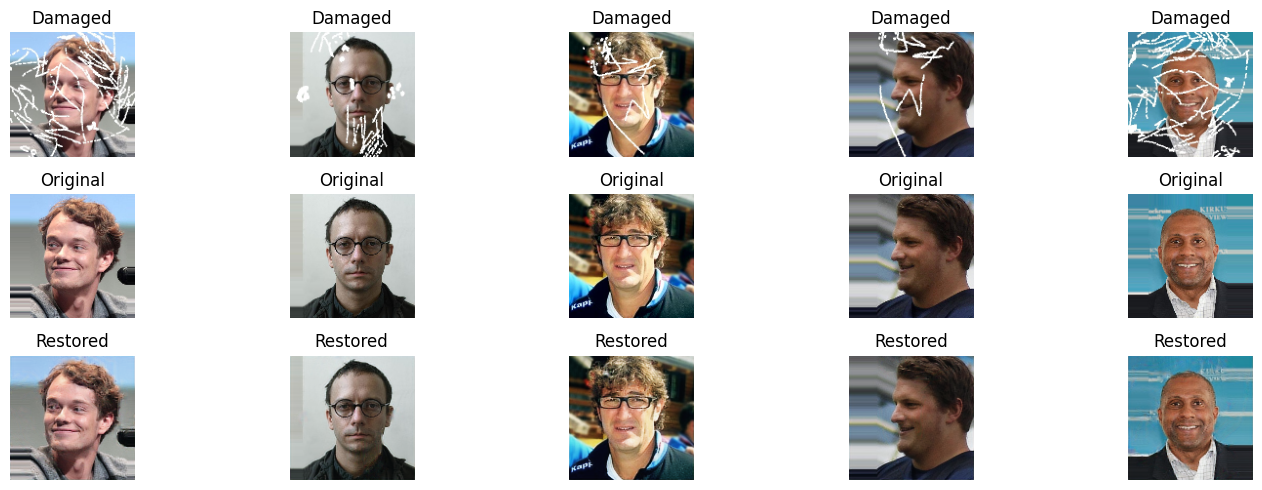

In [ ]:
# Отображение результата
visualize_results(X_test, y_test, model)

In [ ]:
# Сохранение
model.save("restoration_unet_vgg.h5")